In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline,FeatureUnion


from scipy.stats import uniform, randint  
import numpy as np

In [2]:
import nltk;
from nltk.stem import WordNetLemmatizer;
from nltk.corpus import stopwords;
nltk.download('punkt');
nltk.download('wordnet');
nltk.download('stopwords');


[nltk_data] Downloading package punkt to C:\Users\stand-
[nltk_data]     svyaz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\stand-
[nltk_data]     svyaz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\stand-
[nltk_data]     svyaz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
%pip install spacy
!python -m spacy download en_core_web_sm
import spacy

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 660.6 kB/s eta 0:00:20
     ---------------------------------------- 0.1/12.8 MB 1.4 MB/s eta 0:00:09
     - -------------------------------------- 0.5/12.8 MB 3.1 MB/s eta 0:00:04
     --- ------------------------------------ 1.1/12.8 MB 5.6 MB/s eta 0:00:03
     -------- ------------------------------- 2.7/12.8 MB 11.4 MB/s eta 0:00:01
     ------------------ --------------------- 5.8/12.8 MB 20.6 MB/s eta 0:00:01
     ------------------ --------------------- 5.8/12.8 MB 20.6 MB/s eta 0:00:01
     ------------------ --------------------- 5.8/12.8 MB 20.6 MB/s eta 0:00:01
     ------------------ --------------------- 5.8/12.8 MB 13.8 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.8 MB 15.7 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.8 MB 15.7 MB

In [4]:
%pip install transformers
from transformers import BertTokenizer,BertForSequenceClassification

In [5]:
%pip install torch torchvision 
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install lightgbm
from lightgbm import LGBMClassifier

Note: you may need to restart the kernel to use updated packages.


In [7]:
from tqdm.notebook import tqdm
tqdm.pandas()

# Проект для «Викишоп» BERT

В проекте перед нами стоит задача классификации твитов. На полученном датасете обучались и тестировались две модели (BERT и логистическая регрессия). Для первой модели датасет был существенно урезан.

План работы:
+ Хагрузка данных
+ Обучение модели BERT
+ Обучение модели логистической регрессии
+ Общий вывод

## Загрузка данных

In [8]:
toxic_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [9]:
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [10]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


### Баланс классов

<AxesSubplot:title={'center':'Процентное соотношение классов'}>

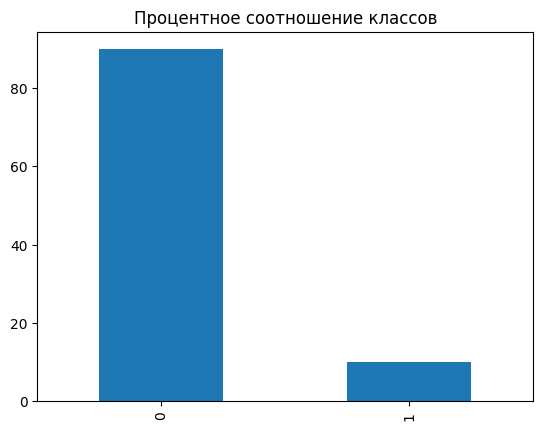

In [11]:
class_counts = toxic_comments['toxic'].value_counts()
class_percentages = class_counts / len(toxic_comments) * 100
class_percentages.plot(kind='bar', title='Процентное соотношение классов')

### Создание подвыборки из полного датасета

In [12]:
toxic_comments_crop =  toxic_comments.sample(n=3000, random_state=78)

___Вывод после знакомства с данными:___ Полученный датасет содержит примерно 160 строк, что представляет сложно для применения модели BERT. Была сделана подвыборка. Так же обнаружен дисбаланс классов.

## Подготовка данных для BERT

## Разделение выборок 

In [13]:
RANDOM_STATE= 78
features = toxic_comments_crop.drop(columns=['Unnamed: 0','toxic'])
target = toxic_comments_crop['toxic']
X_train,X_test,y_train,y_test = train_test_split(features,target, test_size = 0.5, random_state= RANDOM_STATE)

### Токенизация

In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [15]:
max_length = 512
X_train_tokenized = [tokenizer.encode(text, add_special_tokens=True, max_length=max_length, truncation=True) for text in X_train['text']]
X_test_tokenized = [tokenizer.encode(text, add_special_tokens=True, max_length=max_length, truncation=True) for text in X_test['text']]

### Загрузка модели BERT

In [16]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Приведение всех последовательностей к одной длине

In [17]:
max_length_tr = max(len(seq) for seq in X_train_tokenized)
X_train_padded = pad_sequence([torch.tensor(seq) for seq in X_train_tokenized], batch_first=True, padding_value=0)
max_length_te = max(len(seq) for seq in X_test_tokenized)
X_test_padded = pad_sequence([torch.tensor(seq) for seq in X_test_tokenized], batch_first=True, padding_value=0)

### Преобразование токенизированных текстов в тензоры PyTorch

In [18]:
train_input_ids = torch.tensor(X_train_padded)
train_labels = torch.tensor(y_train.values)

C:\Users\stand-svyaz\AppData\Local\Temp\ipykernel_1904\3620340503.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input_ids = torch.tensor(X_train_padded)


In [19]:
test_input_ids = torch.tensor(X_test_padded)
test_labels = torch.tensor(y_test.values)

C:\Users\stand-svyaz\AppData\Local\Temp\ipykernel_1904\2598213757.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_input_ids = torch.tensor(X_test_padded)


### Создание DataLoader для обучающей и тестовой выборок

In [20]:
train_dataset = TensorDataset(train_input_ids,train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [21]:
test_dataset = TensorDataset(test_input_ids, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32)


### Обучение модели

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

In [23]:
for epoch in range(3):
    model.train()
    for batch in train_loader:
     input_ids,labels = batch  
     attention_mask = (input_ids != tokenizer.pad_token_id).type(torch.FloatTensor)
     optimizer.zero_grad()
     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)  
     loss = outputs.loss
     loss.backward()
     optimizer.step()

In [24]:
model.eval()
predictions = []
true_labels = []

In [25]:
for batch in test_loader:
    input_ids,labels = batch  
    attention_mask = (input_ids != tokenizer.pad_token_id).type(torch.FloatTensor)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)  
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())



In [26]:
f1 = f1_score(true_labels, predictions)
print("F1 Score:", round(f1,2))

F1 Score: 0.79


### Вывод по модели

___Вывод по модели:___ Модель BERT, в силу её требовательности к вычислительным мощностям пришлось обучать на сильно урезанном датасете. Тем не менее результат получился весьма неплохим

## Модели логистической регресии и LightGBM

In [27]:
#toxic_comments_crop_tf =  toxic_comments.sample(n=100000, random_state=78)

### Лемматизация через SpaCy

In [28]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words = set(stopwords.words('english'))

In [29]:
def preprocess_text(text):
    doc = nlp(text.lower()) # Токенизация и приведение к нижнему регистру
    lemmas = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stop_words] # Лемматизация и удаление стоп-слов
    return ' '.join(lemmas)

In [30]:

toxic_comments['lemm_text'] = toxic_comments['text'].progress_apply(preprocess_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [31]:
toxic_comments.head(10)

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation edit make username hardcore metall...
1,1,D'aww! He matches this background colour I'm s...,0,match background colour I seemingly stick than...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man I really try edit war guy constantly r...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,I make real suggestion improvement I wonder se...
4,4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
5,5,"""\n\nCongratulations from me as well, use the ...",0,congratulation I well use tool well talk
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article revert plea...
8,8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway I intend ...
9,9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


###  Разделение данных

In [32]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(toxic_comments['lemm_text'], toxic_comments['toxic'],\
                                            test_size=0.2,stratify=toxic_comments['toxic'], random_state=78)

###  Построение пайплайна

In [33]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression())
])

In [35]:
param_distributions = [
  
    {
        'model': [LogisticRegression()],
        'model__C': uniform(5, 10)
    },
    
    {
        'model': [LGBMClassifier()],
        'model__num_leaves': randint(10, 100),
        'model__max_depth': randint(5, 20),
        'model__learning_rate': uniform(0.01, 0.1),
        'model__max_depth': range(1, 11)
    }
]

In [36]:
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=5, scoring='f1', random_state=78,verbose=2)

In [37]:
random_search.fit(X_train_1, y_train_1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 10359, number of negative: 91587
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.490598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 449311
[LightGBM] [Info] Number of data points in the train set: 101946, number of used features: 8337
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101613 -> initscore=-2.179434
[LightGBM] [Info] Start training from score -2.179434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=8.25600750485787; total time=   4.0s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=8.25600750485787; total time=   3.7s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=8.25600750485787; total time=   3.6s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=8.25600750485787; total time=   3.7s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=8.25600750485787; total time=   3.6s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=9.440198242192892; total time=   3.8s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=9.440198242192892; total time=   3.7s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=9.440198242192892; total time=   3.7s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=9.440198242192892; total time=   3.6s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=9.440198242192892; total time=   3.7s
[LightGBM] [Info] Number of positive: 10359, number of negative: 91587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.417129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 449311
[LightGBM] [Info] Number of data points in the train set: 101946, number of used features: 8337
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101613 -> initscore=-2.179434
[LightGBM] [Info] Start training from score -2.179434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=9.355720553564858; total time=   3.6s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=9.355720553564858; total time=   3.6s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=9.355720553564858; total time=   3.6s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=9.355720553564858; total time=   3.6s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=9.355720553564858; total time=   3.5s
[LightGBM] [Info] Number of positive: 10359, number of negative: 91587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.421343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 449311
[LightGBM] [Info] Number of data points in the train set: 101946, number of used features: 8337
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101613 -> initscore=-2.179434
[LightGBM] [Info] Start training from score -2.179434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=6.506791268115199; total time=   3.9s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=6.506791268115199; total time=   3.8s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=6.506791268115199; total time=   4.2s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=6.506791268115199; total time=   3.6s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=6.506791268115199; total time=   3.7s


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('model', LogisticRegression())]),
                   param_distributions=[{'model': [LogisticRegression(C=9.355720553564858)],
                                         'model__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EA15C0EC40>},
                                        {'model': [LGBMClassifier()],
                                         'model__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EA1448F370>,
                                         'model__max_depth': range(1, 11),
                                         'model__num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EA3BA39310>}],
                   random_state=78, scoring='f1', verbose=2)

In [38]:
print("Лучшие парамметры модели:", random_search.best_params_)
print("Лучшая оценка F1 score:", random_search.best_score_)

Лучшие парамметры модели: {'model': LogisticRegression(C=9.355720553564858), 'model__C': 9.355720553564858}
Лучшая оценка F1 score: 0.7741845246777893


___Вывод по модели:___ В качестве второй модели была применена модель линейной регресии. В данном случае я использовал весь датасет целиком. Это тоже занимает много времени, но всё же не так много как модель BERT. 

## Общий вывод

В проекте продемонстрировано использование двух моделей для классификации текста - BERT и линейная регрессия. Первая модель выдала хороший результат на трёх тысячах строк ( 2 % от всего датасета). Вторая модель едва выдала необходимое качество работы на всём датасете. Обе модели обучаются достаточно долгое время, но модель BERT по этому показателю заметно лидирует (примерно полтора часа работы). Вероятно скорость обучения можно заметно улучшить с использованием GPU и болле точной настройкой её гипер парамметров.